Сначала нужно посмотреть, какие датасеты мы можем считать (тут есть разные форматы такие как csv, xlsx, ods), а далее посмотрим что у них внутри

In [23]:
import pandas as pd
import os 

with open("info/tables_info.txt", "w") as fout:
    for table in os.listdir("./Проект"):
        df = None

        if table.endswith("csv"):
            df = pd.read_csv("Проект/" + table, on_bad_lines='skip', low_memory=False)
        elif table.endswith("xlsx"):
            try:
                df = pd.read_excel("Проект/" + table)
            except:
                print("[Excel not parsed]", table)
        elif table.endswith("ods"):
            try:
                df = pd.read_excel("Проект/" + table, engine='odf')
            except:
                print("[Ods not parsed]", table)
        else:
            print("[Unknown]", table) 

        if df is not None:
            fout.write(table + "\n")

Смогли считать все датасеты, теперь нужно посмотреть, что у них внутри

In [24]:
with open("info/columns_info.txt", "w") as fout:
    for table in os.listdir("./Проект"):
        df = None

        if table.endswith("csv"):
            df = pd.read_csv("Проект/" + table, on_bad_lines='skip', low_memory=False)
        elif table.endswith("xlsx"):
            try:
                df = pd.read_excel("Проект/" + table)
            except:
                print("[Excel not parsed]", table)
        elif table.endswith("ods"):
            try:
                df = pd.read_excel("Проект/" + table, engine='odf')
            except:
                print("[Ods not parsed]", table)
        else:
            print("[Unknown]", table) 

        if df is not None:
            fout.write(table + "\n")
            fout.write(f"Shape: {df.shape}" + "\n")
            cols = [col for col in list(df.columns.values) if "Unnamed" not in col.strip()]
            fout.write(f"Columns: \n{"\n".join(cols)}\n\n")
            fout.write("#" * 100 + "\n\n")


Смотрим в файл columns_info.txt, чтобы понять, какие колонки у нас есть, в основном это информация о студенте (курс, группа, факультет, фио, почта) и его результаты (оценки, тесты, сдал/не сдал, баллы, проценты, перцентили и т.д.)

Теперь нужно сджойнить все данные в одну таблицу и работать уже с ней.

In [150]:
dfs = []
dfs_names = []

for table in os.listdir("./Проект"):
        df = None

        if table.endswith("csv"):
            df = pd.read_csv("Проект/" + table, on_bad_lines='skip', low_memory=False)
        elif table.endswith("xlsx"):
            try:
                df = pd.read_excel("Проект/" + table)
            except:
                print("[Excel not parsed]", table)
        elif table.endswith("ods"):
            try:
                df = pd.read_excel("Проект/" + table, engine='odf')
            except:
                print("[Ods not parsed]", table)
        else:
            print("[Unknown]", table) 

        if df is not None:
            dfs.append(df)
            dfs_names.append(table)

print(len(dfs))

23


Теперь все таблицы лежат в списке dfs, их имена в dfs_names

Теперь нам нужен уникальный id для человека, брать ФИО мы не можем, так как будут коллизии, поэтому будем использовать почту (при коллизии к почте добавляется номер человека), при этом такой выбор согласуется с логикой, ведь было бы странно если бы вуз раздавал одинаковые почты в своем домене. Теперь нужно найти все почты и далее приджойнить все колонки из таблиц.

В Таблице НЭ_с_2021я таблица для дэшборда.xlsx есть дубликаты почт, потому что это результаты за несколько лет обучения, поэтому нужно объединить их под одну почту

In [151]:
dfs[-1].columns.values

array(['ФИО', 'Адрес электронной почты', 'Филиал', 'Факультет', 'ОП',
       'Группа', 'Курс', 'ОЦЕНКА', 'НЭ', 'Год', 'Поток', 'Онлайн-курс',
       'ИУС', 'Демо-версия', 'Сдал/не сдал', 'Сдал-не-сдал',
       'Больше половины онлайн-курса', 'Оценка за онлайн курс', 'Чек'],
      dtype=object)

In [ ]:
# CHANGED BLOCK!!!!

# Create base dataframe with sequential counter
df = dfs[-1].copy()
df['seq_num'] = df.groupby('Адрес электронной почты').cumcount() + 1

# Define columns to pivot
pivot_columns = {
    'ОЦЕНКА': 'ОЦЕНКА_',
    'Год': 'Год_',
    'Курс': 'Курс_',
    'Онлайн-курс': 'Онлайн-курс_',
    'ИУС': 'ИУС_',
    'Демо-версия': 'Демо-версия_',
    'Сдал-не-сдал': 'Сдал-не-сдал_'
}

# Create all pivot tables at once
pivot_tables = {
    prefix: df.pivot(
        index='Адрес электронной почты',
        columns='seq_num',
        values=col
    ).add_prefix(prefix)
    for col, prefix in pivot_columns.items()
}

# Get email metadata (first occurrence for each email)
email_metadata = df.groupby('Адрес электронной почты').first()

# Combine all pieces
result_df = pd.concat([email_metadata] + list(pivot_tables.values()), axis=1)

# Clean up the result
columns_to_drop = [
    'Группа', 'Курс', 'ОЦЕНКА', 'Год', 'Онлайн-курс', 'ИУС', 
    'Демо-версия', 'Сдал-не-сдал', 'Сдал/не сдал',
    'Больше половины онлайн-курса', 'Чек', 'Оценка за онлайн курс'
]
result_df = (result_df
    .fillna('')
    .reset_index()
    .drop(columns=columns_to_drop)
)

KeyError: 'ОЦЕНКА'

In [155]:
old_ie = dfs[-1].copy()
dfs[-1] = result_df

In [156]:
email_cols = set(["Адрес электронной почты", "Email address", "Адрес студенческой почты", "Логин"])

for i in range(len(dfs)):
    cols = dfs[i].columns.values
    if len(email_cols.intersection(cols)) == 0:
        print(i, dfs_names[i])
        print(cols)
        print()

Здесь я нашел все колонки, где может быть почта, ведь они могут иметь разные названия в разных таблицах

In [157]:
emails = []

for i in range(len(dfs)):
    for email_col in email_cols:
        if email_col in dfs[i].columns.values:
            emails.extend(dfs[i][email_col].values)
            break

In [158]:
emails = list(set(emails))
print(len(emails))

emails = [x for x in emails if isinstance(x, str)]
print(len(set(emails)), len(emails))

123452
123451 123451


Тут я получил множество всех уникальных почт людей, теперь можно приджойнить все таблицы по почте

In [159]:
df_all = pd.DataFrame(emails, columns=["email"])

for i in range(len(dfs)):
    for email_col in email_cols:
        if email_col in dfs[i].columns.values:
            df_renamed = dfs[i].copy()
            df_renamed.rename(columns={col: f"{col}_{dfs_names[i]}" for col in dfs[i].columns.values}, inplace=True)

            df_all = pd.merge(df_all, df_renamed,
                                left_on='email',
                                right_on=email_col + "_" + dfs_names[i],
                                how='left',
                                suffixes=('_df1', '_df2'))
            if len(df_all['email'].unique().tolist()) != len(df_all['email'].tolist()):
                print("Duplicate emails!!!")
            break


df_all.head()

,email,Unnamed: 0_Выполнение елементов учебника по АД_нач_англ.csv,Адрес электронной почты_Выполнение елементов учебника по АД_нач_англ.csv,Данные о пользователе_Выполнение елементов учебника по АД_нач_англ.csv,User information_Выполнение елементов учебника по АД_нач_англ.csv,Страна_Выполнение елементов учебника по АД_нач_англ.csv,Forum_Выполнение елементов учебника по АД_нач_англ.csv,Unnamed: 6_Выполнение елементов учебника по АД_нач_англ.csv,Specification of the Independent Data Science Test of Elementary Level_Выполнение елементов учебника по АД_нач_англ.csv,Unnamed: 8_Выполнение елементов учебника по АД_нач_англ.csv,...,Демо-версия_3_НЭ_с_2021я таблица для дэшборда.xlsx,Демо-версия_4_НЭ_с_2021я таблица для дэшборда.xlsx,Демо-версия_5_НЭ_с_2021я таблица для дэшборда.xlsx,Демо-версия_6_НЭ_с_2021я таблица для дэшборда.xlsx,Сдал-не-сдал_1_НЭ_с_2021я таблица для дэшборда.xlsx,Сдал-не-сдал_2_НЭ_с_2021я таблица для дэшборда.xlsx,Сдал-не-сдал_3_НЭ_с_2021я таблица для дэшборда.xlsx,Сдал-не-сдал_4_НЭ_с_2021я таблица для дэшборда.xlsx,Сдал-не-сдал_5_НЭ_с_2021я таблица для дэшборда.xlsx,Сдал-не-сдал_6_НЭ_с_2021я таблица для дэшборда.xlsx
0,aabuinovskaia@edu.hse.ru,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,aaustinov_2@edu.hse.ru,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,psoseneva@edu.hse.ru,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,,,,,1,0,1,,,
3,s6569024515@edu.hse.ru,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,s8591967012@edu.hse.ru,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [160]:
df_all[df_all['email'].duplicated()]['email'].unique()
# df_all[df_all['email'] == 'psoseneva@edu.hse.ru']

array([], dtype=object)

здесь я удалю все колонки, где нет имени

In [161]:
df_all.drop([col for col in df_all.columns.values if 'Unnamed' in col], axis=1, inplace=True)
print(len(list(df_all.columns.values)))

1102


здесь я выделил все колонки, где есть полезная информация


In [163]:
col_patterns = ['test', 'тест', 'оценка', 'variant', 'вариант', 'practice', 'hypothesis', 'практика'
             'гипотеза', 'задание', 'task', 'самопроверка', 'лекция', 'инструмент', 'видео', 
             'глава', 'quiz', 'норм', 'сумма', 'перцентиль', 'балл', 'место', 'course', ]

used_cols = [col for col in df_all.columns.values if any([pat in col.lower() for pat in col_patterns])]

df_used = df_all[used_cols + ['email']]
df_used.shape

(123451, 766)

Тут я прохожусь по всем значениям большой таблицы и пытаюсь преобзовать их в числа для дальнейшего обучения модели

In [164]:
for x in df_used.drop(columns=['email'], inplace=False).values.flatten().tolist():
    if isinstance(x, float):
        continue
    if isinstance(x, str) and x == '':
        continue
    if isinstance(x, str) and '/' in x:    
        a, b = x.split('/')
        a, b = a.strip(), b.strip()
        try:
            if a.lower() == 'null' or b.lower() == 'null':
                c = 1
            else:
                c = float(a) / float(b)
        except Exception as e:
            print(e, x)
        continue
    if x in ['Выполнено', 'Не выполнено', '-']:
        continue
    try:
        if isinstance(x, str):
            x = x.replace(',', '.')
        x = float(x)
    except Exception as e:
        print(e, x)

In [165]:
import math

def process_value(x):
    if type(x) == float and math.isnan(x):
        return 0

    if isinstance(x, float):
        return x
    if isinstance(x, str) and x == '':
        return 0
    if isinstance(x, str) and '/' in x:
        a, b = x.split('/')
        a, b = a.strip(), b.strip()
        if a.lower() == 'null' or b.lower() == 'null':
            return 1.0
        return float(a) / float(b)
    
    if isinstance(x, str):
        if x.lower() == 'выполнено':
            return 1.0
        elif x.lower() in ['не выполнено', '-']:
            return 0.0
        x = x.replace(',', '.')
    
    return float(x)

processed_df = df_used.drop(columns=['email'], inplace=False).apply(lambda x: x.apply(process_value))
processed_df['email'] = df_used['email']
processed_df.shape

(123451, 766)

Теперь в таблице processed_df все значения преобразованы в числа и можно обучать модель, но для начала нужно разделить данные на тренировочную и тестовую выборки


Из текущего датасета нужно вытащить целевую переменную, остальное берем как признаковое описание.
Таргетом будет оценка за независимый экзамен, поэтому будем использовать лишь множество почт из этой таблицы (НЭ_с_2021я таблика для дэщборда.xlsx)

In [167]:
with open("info/processed_columns_info.txt", "w", encoding='utf-8') as fout:
    fout.write(f"Total number of columns: {len(processed_df.columns)}\n\n")
    fout.write("Columns:\n")
    for i, col in enumerate(processed_df.columns, 1):
        fout.write(f"{i}. {col}\n")

Нашел ее название в общей таблице - "ОЦЕНКА_{год обучения}_НЭ_с_2021я таблица для дэшборда.xlsx", значит нужно завести новую колонку target, которая будет отвечать за последную оценку студента по НЭ.
И не забудем ограничить датасет по почтам, для которых мы знаем таргет.

In [ ]:
import pandas as pd

# Get all grade columns
grade_cols = [f'ОЦЕНКА_{i}_НЭ_с_2021я таблица для дэшборда.xlsx' for i in range(1, 7)]

# Create grade_last column by checking each grade column from right to left
processed_df['target'] = processed_df[grade_cols].replace(0, np.nan).ffill(axis=1).iloc[:, -1]
processed_df = processed_df[processed_df['target'].notna()]
print(processed_df.shape)

(28112, 767)


In [ ]:
valid_emails = set(pd.read_excel("Проект/НЭ_с_2021я таблица для дэшборда.xlsx")["Адрес электронной почты"].values)
print(len(valid_emails))

filtered_df = processed_df[processed_df['email'].isin(valid_emails)]
filtered_df.shape

(28112, 767)

Для начала предположим, что время для нас не особо влияет (год сдачи теста / экзамена), важно лишь сдал ли его студент или нет, то есть учитывать будем лишь "знания человека". При таком принципе можно поделить датасет случайно в пропорции 70/30 и замерить качество в предсказании целевой переменной (итоговой экзамен).

Для начала давайте обучим бейзлайн модель, с которой будем сравнивать результаты. Давайте вспомним, что в данной задаче нам нужно максимизировать recall, то есть добиться максимального покрытия множество людей, которые не сдадут экзамен, ведь наше дело предупредить студента или его учителя, что есть проблемы с изучением курса, а если мы посоветуем дополнительные занятия человека, который и без них бы сдал экзамен, то ничего плохого не произойдет.

In [171]:
int_cols = filtered_df.select_dtypes(include=['int64']).columns
filtered_df[int_cols] = filtered_df[int_cols].astype('float64')

X = filtered_df.drop(columns=['email', 'target'] + grade_cols)
y = filtered_df['target']

print(X.dtypes.unique(), y.dtypes)

[dtype('float64')] float64


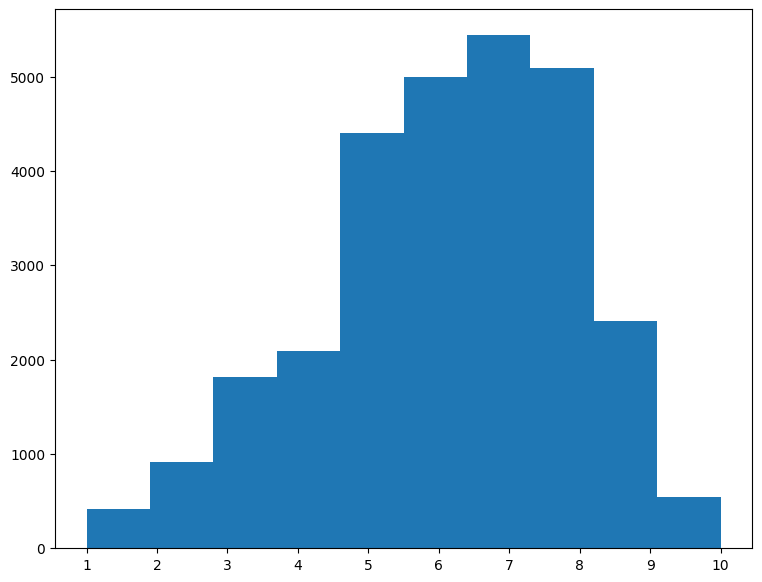

In [172]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(9, 7))
plt.hist(y, bins=10)
plt.xticks(np.arange(1, 11, 1))
plt.show()


Распределение целевой переменной ожидаемое, имеет среднее 6-7, больше смещено в сторону 5+

На данный момент получили обучающую выборку, теперь нужно разделить ее на тренировочную и тестовую в пропорции 70/30 и замерить качество на разных моделях.

In [173]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(19678, 759) (19678,)
(8434, 759) (8434,)


Теперь займемся обучением моделей и замером качества, измерять качество будем по RMSE, чтобы знать среднее отклонение предсказаний от истинных значений. 

Начнем с линейной регрессии, только не забудем нормализовать признаки.

In [174]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize the scaler
scaler = StandardScaler()

# Fit scaler on training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# Calculate RMSE for both training and test sets
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f'Training RMSE: {rmse_train:.4f}')
print(f'Test RMSE: {rmse_test:.4f}')

# Optional: Print feature coefficients
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_
}).sort_values('Coefficient', key=lambda x: x, ascending=False).head(10)
print('\nFeature Coefficients:')
print(feature_importance)

Training RMSE: 1.7386
Test RMSE: 1.7915

Feature Coefficients:
                                               Feature  Coefficient
539             Место в кампусе_Рейтинг 23-24 года.csv     6.124167
752                  Перцентиль_Рейтинг 21-22 года.csv     5.292704
24   Итоговая оценка за курс (Значение)_Курс подгот...     3.629707
360  Итоговая оценка за курс (Значение)_Курс подгот...     2.669379
739                  Перцентиль_Рейтинг 22-23 года.csv     2.233789
755                 Место на ОП_Рейтинг 21-22 года.csv     1.871596
733                    КР сумма_Рейтинг 22-23 года.csv     1.306099
753              Средняя оценка_Рейтинг 21-22 года.csv     1.159205
532                Норм коэф ГР_Рейтинг 23-24 года.csv     0.546546
576          Балл ЕГЭ_Выгрузка по ЕГЭ с 2020 года.xlsx     0.391131


Теперь сразу попробуем обучить сильную модель - градиентный бустинг, посмотрим на сколько улучшится качество

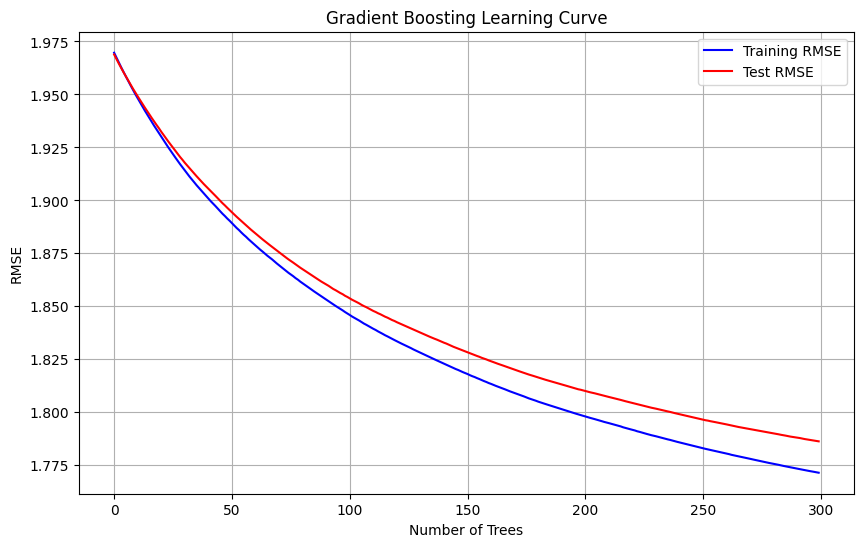


Feature Importances:
                                               Feature  Importance
576          Балл ЕГЭ_Выгрузка по ЕГЭ с 2020 года.xlsx    0.252301
753              Средняя оценка_Рейтинг 21-22 года.csv    0.161389
116  Итоговая оценка за курс (Значение)_ЦГ_Учебник ...    0.107101
48   Тест:Случайный вариант из Открытого банка (Зна...    0.065126
67   Тест:Выписка заданий №11: Большие данные. (Зна...    0.037617
756             Место в кампусе_Рейтинг 21-22 года.csv    0.036375
740              Средняя оценка_Рейтинг 22-23 года.csv    0.035635
733                    КР сумма_Рейтинг 22-23 года.csv    0.025649
752                  Перцентиль_Рейтинг 21-22 года.csv    0.024291
378  Тест:Тема 2. Задачи для самопроверки — 1 (Знач...    0.015894

Final Training RMSE: 1.7715
Final Test RMSE: 1.7863


In [179]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Initialize model
gb_model = GradientBoostingRegressor(
    n_estimators=300,        # number of trees
    learning_rate=0.01,       # shrinkage rate
    # max_depth=3,            # depth of each tree
    # subsample=0.8,          # fraction of samples for each tree
    # random_state=42,
    # validation_fraction=0.1  # fraction of training data to use for early stopping
)

# Train model and store losses
gb_model.fit(X_train_scaled, y_train)

# Get staged predictions and calculate RMSE for each stage
train_losses = []
test_losses = []

for y_train_pred in gb_model.staged_predict(X_train_scaled):
    train_losses.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    
for y_test_pred in gb_model.staged_predict(X_test_scaled):
    test_losses.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training RMSE', color='blue')
plt.plot(test_losses, label='Test RMSE', color='red')
plt.xlabel('Number of Trees')
plt.ylabel('RMSE')
plt.title('Gradient Boosting Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

# Print feature importances
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': gb_model.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

print("\nFeature Importances:")
print(feature_importance)

# Make final predictions
y_pred_train = gb_model.predict(X_train_scaled)
y_pred_test = gb_model.predict(X_test_scaled)

print(f"\nFinal Training RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.4f}")
print(f"Final Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")

Попробуем обучится на лимитированном пуле фичей, на данный момент их слишком много, а пропусков еще больше

In [187]:
non_zero_counts = (X_train != 0).sum()
top_features = non_zero_counts.sort_values(ascending=False).head(50)
top_features.index.tolist()

X_train_lim = X_train[top_features.index.tolist()]
X_test_lim = X_test[top_features.index.tolist()]

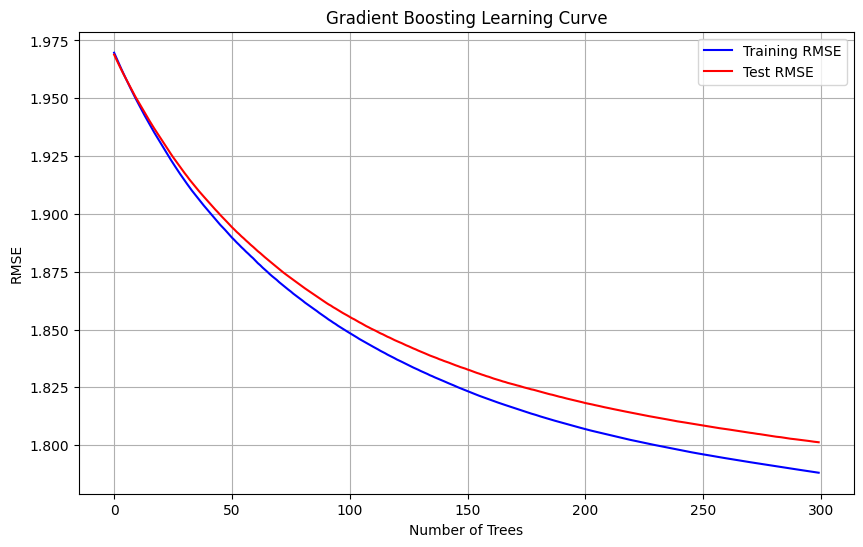


Feature Importances:
                                              Feature  Importance
0           Балл ЕГЭ_Выгрузка по ЕГЭ с 2020 года.xlsx    0.279761
34              Средняя оценка_Рейтинг 21-22 года.csv    0.178595
1   Итоговая оценка за курс (Значение)_ЦГ_Учебник ...    0.147372
47  Тест:Случайный вариант из Открытого банка (Зна...    0.097171
28             Место в кампусе_Рейтинг 21-22 года.csv    0.041054
22              Средняя оценка_Рейтинг 22-23 года.csv    0.036711
45  Тест:1.4 Задачи для тренировки (Значение)_Учеб...    0.032637
21                    КР сумма_Рейтинг 22-23 года.csv    0.029377
37                  Перцентиль_Рейтинг 21-22 года.csv    0.025519
27           Место на Курсе-ОП_Рейтинг 21-22 года.csv    0.018074

Final Training RMSE: 1.7881
Final Test RMSE: 1.8013


In [189]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

scaler = StandardScaler()

# Fit scaler on training data and transform both training and test data
X_train_lim_scaled = scaler.fit_transform(X_train_lim)
X_test_lim_scaled = scaler.transform(X_test_lim)

# Initialize model
gb_model = GradientBoostingRegressor(
    n_estimators=300,        # number of trees
    learning_rate=0.01,       # shrinkage rate
    # max_depth=3,            # depth of each tree
    # subsample=0.8,          # fraction of samples for each tree
    # random_state=42,
    # validation_fraction=0.1  # fraction of training data to use for early stopping
)

# Train model and store losses
gb_model.fit(X_train_lim_scaled, y_train)

# Get staged predictions and calculate RMSE for each stage
train_losses = []
test_losses = []

for y_train_pred in gb_model.staged_predict(X_train_lim_scaled):
    train_losses.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    
for y_test_pred in gb_model.staged_predict(X_test_lim_scaled):
    test_losses.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training RMSE', color='blue')
plt.plot(test_losses, label='Test RMSE', color='red')
plt.xlabel('Number of Trees')
plt.ylabel('RMSE')
plt.title('Gradient Boosting Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

# Print feature importances
feature_importance = pd.DataFrame({
    'Feature': X_train_lim.columns,
    'Importance': gb_model.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

print("\nFeature Importances:")
print(feature_importance)

# Make final predictions
y_pred_train = gb_model.predict(X_train_lim_scaled)
y_pred_test = gb_model.predict(X_test_lim_scaled)

print(f"\nFinal Training RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.4f}")
print(f"Final Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")

Получилось не лучше, поэтому можем оставить весь список признаков

Еще один подход, который можно использовать, это использовать классификацию, то есть предсказывать не оценку, а факт сдачи экзамена. Для этого нужно будет перевести целевую переменную в бинарную, сделаем для этого `binary_target = (target < 4)`, то есть не сдавшие экзамен будут считаться положительными примерами, а не сдавшие - отрицательными.

In [193]:
y_train_binary = (y_train < 4)
y_test_binary = (y_test < 4)

Training metrics:
Precision: 0.6761
Recall: 0.0657
AUC: 0.7750

Test metrics:
Precision: 0.2893
Recall: 0.0367
AUC: 0.7068


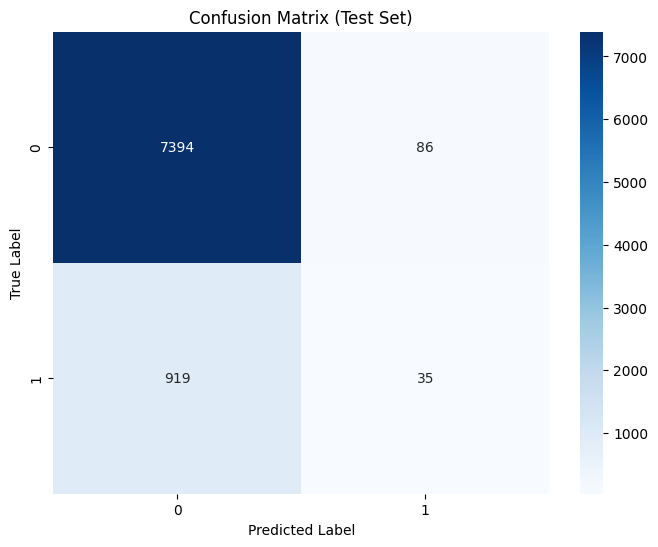


Top 10 Most Important Features:
                                               Feature  Coefficient
729  Видео | Excel: тепловые карты_Выполнение елеме...     0.901164
707  Видео | Excel: линейная регрессия — 2_Выполнен...     0.729750
242  Видео | Python: корреляция_Выполнение елементо...     0.720062
294  Видео | Excel: рассчитываем t-тест —2_Выполнен...     0.601084
753              Средняя оценка_Рейтинг 21-22 года.csv     0.599985
690  Видео | Python: разведочный анализ данных — 1_...     0.594591
702  Видео | Теория: множественная линейная регресс...     0.569723
280  Видео | Python: рассчитываем критерий хи-квадр...     0.565434
531             КРгр сумма норм_Рейтинг 23-24 года.csv     0.565421
727  Видео | Excel: разведочный анализ_Выполнение е...     0.549490


In [194]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize and train logistic regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train_binary)

# Make predictions
y_pred_train_binary = lr_model.predict(X_train_scaled)
y_pred_test_binary = lr_model.predict(X_test_scaled)

# Get probability predictions for AUC
y_pred_train_proba = lr_model.predict_proba(X_train_scaled)[:, 1]
y_pred_test_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
print("Training metrics:")
print(f"Precision: {precision_score(y_train_binary, y_pred_train_binary):.4f}")
print(f"Recall: {recall_score(y_train_binary, y_pred_train_binary):.4f}")
print(f"AUC: {roc_auc_score(y_train_binary, y_pred_train_proba):.4f}")

print("\nTest metrics:")
print(f"Precision: {precision_score(y_test_binary, y_pred_test_binary):.4f}")
print(f"Recall: {recall_score(y_test_binary, y_pred_test_binary):.4f}")
print(f"AUC: {roc_auc_score(y_test_binary, y_pred_test_proba):.4f}")

# Plot confusion matrix for test set
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_binary, y_pred_test_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print feature importances
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': abs(lr_model.coef_[0])
}).sort_values('Coefficient', ascending=False).head(10)

print("\nTop 10 Most Important Features:")
print(feature_importance)

Из-за большого дисбаланса классов модель не может выучить закономерности положительного класса, нужно больше примеров